# Investigating summary statistics

This notebook tries to evaluate useful summary statistics for an event-related potential (averaged signal of an EEG).
The following evaluations are used:

- post predictive checks
- KL-divergence between $p(\Theta|x)$ and $p(\Theta|x_1)$ (in order to see if KL-divergence increases when certain feature is missing. This would indicate that this feature is important
- ratio of variances of the marginals $p(\Theta|x)$ and $p(\Theta|x_1)$. A high ratio would mean that feature is important (close to 1 would mean that the missing would not change much). 
- histogram plots that compare which feature values prior simulations would cause versus which feature values the posterior simulations cause. We should expect that the posterior histogram distributions are narrower but around the 'true oberservation' (that we unfortunately do not have for real).

In [1]:
%load_ext autoreload
%autoreload 2
import os.path as op
import tempfile

import matplotlib.pyplot as plt


import hnn_core
from hnn_core import simulate_dipole, jones_2009_model
from hnn_core.viz import plot_dipole


import sys
sys.path.append('../code/')
sys.path.append('../../results_cluster/')


import numpy as np
import torch

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

# sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi



# import the summary statistics that you want to investigate
from summary_features.calculate_summary_features import calculate_summary_statistics_alternative as alternative_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_temporal as temporal_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_number as number_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_temporal


In [2]:
print(torch.__version__)

1.9.1+cu102


In [3]:
## defining neuronal network model

from utils.simulation_wrapper import event_seed, set_network_default, simulation_wrapper,simulation_wrapper_obs, simulation_wrapper_all

sim_wrapper = simulation_wrapper_all


In [4]:
window_len = 30
prior_min = [0, 0, 0, 0, 17.3, 0, 0, 0, 0, 0, 0, 51.980, 0, 0, 0, 0, 112.13]
prior_max = [0.927, 0.160, 2.093, 0.0519, 35.9, 0.039, 0.000042, 0.854, 0.117, 0.0259, 0.480, 75.08, 0.0000018, 8.633, 0.0537, 4.104, 162.110]

prior = utils.torchutils.BoxUniform(low=prior_min, high=prior_max)

#number_simulations = 10
density_estimator = 'nsf'


In [5]:

assert (prior.event_shape==torch.Size([6]))
from utils import inference

AssertionError: 

In [6]:
from utils import inference
from utils.simulation_wrapper import event_seed, simulation_wrapper
import pickle
from data_load_writer import *
from data_load_writer import load_from_file as lf

import os

work_dir = '/home/ubuntu/sbi_for_eeg_data/'

os.chdir(work_dir)



import os

print(os.getcwd())

#os.chdir('/home/kathi/Documents/Master_thesis/results_cluster/')



print(os.getcwd())

os.chdir('/home/ubuntu/results/')

## loading simulations from previously saved computations
#file = 'ERP_sequential_3params/step3'
#file = 'ERP_save_sim_nsf_num_params3'
#file = 'eval_features'
file = '10000_sims_17_params'
  

thetas = torch.load('{}/step3/thetas.pt'.format(file))
x_without = torch.load('{}/step3/obs_without.pt'.format(file))

x = calculate_summary_stats_temporal(x_without)


#true_params = torch.tensor([[0.0274, 19.01, 0.1369, 61.89, 0.1435, 120.86]])
#true_params = torch.tensor([[  18.9700, 63.5300, 137.1200]])
#true_params = torch.load('results/{}/true_params.pt'.format(file))
true_params = torch.tensor([[0.277, 0.0399, 0.3739, 0.034, 18.977, 0.0115, 0.000012, 0.466, 0.06337, 0.0134, 0.0766, 63.08, 0.000005, 4.6729, 0.0115, 0.3308, 120.86]])

print(true_params)

/home/ubuntu/sbi_for_eeg_data
/home/ubuntu/sbi_for_eeg_data
tensor([[2.7700e-01, 3.9900e-02, 3.7390e-01, 3.4000e-02, 1.8977e+01, 1.1500e-02,
         1.2000e-05, 4.6600e-01, 6.3370e-02, 1.3400e-02, 7.6600e-02, 6.3080e+01,
         5.0000e-06, 4.6729e+00, 1.1500e-02, 3.3080e-01, 1.2086e+02]])


## Inference step:

In [7]:
density_estimator = 'nsf'



inf = SNPE(prior=prior, density_estimator = density_estimator)

#inf = SNPE_C(prior, density_estimator="nsf")

inf = inf.append_simulations(thetas, x)

density_estimator = inf.train()

posterior = inf.build_posterior(density_estimator)


#true_params = torch.tensor([[26.61, 63.53,  137.12]])

Neural network successfully converged after 42 epochs.


## Simulation under 'true parameters'

In [8]:
obs_real = inference.run_only_sim(true_params, simulation_wrapper = sim_wrapper)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
early stop 170.0
param size  17
is here the problem?
check
joblib will run over 1 jobs
Loading custom mechanism files from /home/ubuntu/miniconda3/envs/sbi_env/lib/python3.7/site-packages/hnn_core/mod/x86_64/.libs/libnrnmech.so
Building the NEURON model
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
Simulation time: 10.0 ms...
Simulation time: 20.0 ms...
Simulation time: 30.0 ms...
Simulation time: 40.0 ms...
Simulation time: 50.0 ms...
Simulation time: 60.0 ms...
Simulation time: 70.0 ms...
Simulation time: 80.0 ms...
Simulation time: 90.0 ms...
Simulation time: 100.0 ms...
Simulation time: 110.0 ms...
Simulation time: 120.0 ms...
Simulation time: 130.0 ms...
Simulation time: 140.0 ms...
Simulation time: 150.0 ms...
Simulation time: 160.0 ms...
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   41.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   41.4s finishe

In [9]:
obs = obs_real

In [10]:
print(obs_real[0].shape)

torch.Size([6801])


In [11]:
obs_real = calculate_summary_stats_temporal(obs_real)

samples = posterior.sample((10000,), x=obs_real)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [46]:


parameter_names = ["prox_1_ampa_l2_bas\nstep1","prox_1_ampa_l2_pyr\nstep1","prox_1_ampa_l5_bas\nstep1","prox_1_ampa_l5_pyr\nstep1",
 "t_evprox_1\nstep1",
 "dist_ampa_l2_bas\nstep2","dist_ampa_l2_pyr\nstep2","dist_ampa_l5_pyr\nstep2",
 "dist_nmda_l2_bas\nstep2","dist_nmda_l2_pyr\nstep2","dist_nmda_l5_pyr\nstep2",
 "t_evdist_1\nstep2", 
 "prox_2_ampa_l2_bas\nstep3","prox_2_ampa_l2_pyr\nstep3","prox_2_ampa_l5_bas\nstep3","prox_2_ampa_l5_pyr\nstep3",
 "t_evprox_2\nstep3"]

In [47]:
print(samples[0][14])
true_params[0][14]

tensor(0.0320)


tensor(0.0115)

In [48]:
##better limits:

list_min = list(torch.min(samples, 0)[0]-0.15)
list_max = list(torch.max(samples, 0)[0]+0.15)

limits = [list(tup) for tup in zip(list_min, list_max)]
limits

[[tensor(-0.1450), tensor(1.0759)],
 [tensor(-0.1348), tensor(0.3096)],
 [tensor(-0.0201), tensor(2.2417)],
 [tensor(-0.1257), tensor(0.2018)],
 [tensor(17.1559), tensor(20.2729)],
 [tensor(-0.1500), tensor(0.1890)],
 [tensor(-0.1500), tensor(0.1500)],
 [tensor(-0.1494), tensor(1.0039)],
 [tensor(-0.1486), tensor(0.2670)],
 [tensor(-0.1500), tensor(0.1759)],
 [tensor(-0.1452), tensor(0.2723)],
 [tensor(59.1508), tensor(66.0153)],
 [tensor(-0.1500), tensor(0.1500)],
 [tensor(-0.1497), tensor(8.7811)],
 [tensor(-0.1500), tensor(0.2037)],
 [tensor(-0.1489), tensor(4.1458)],
 [tensor(112.8734), tensor(156.9824)]]

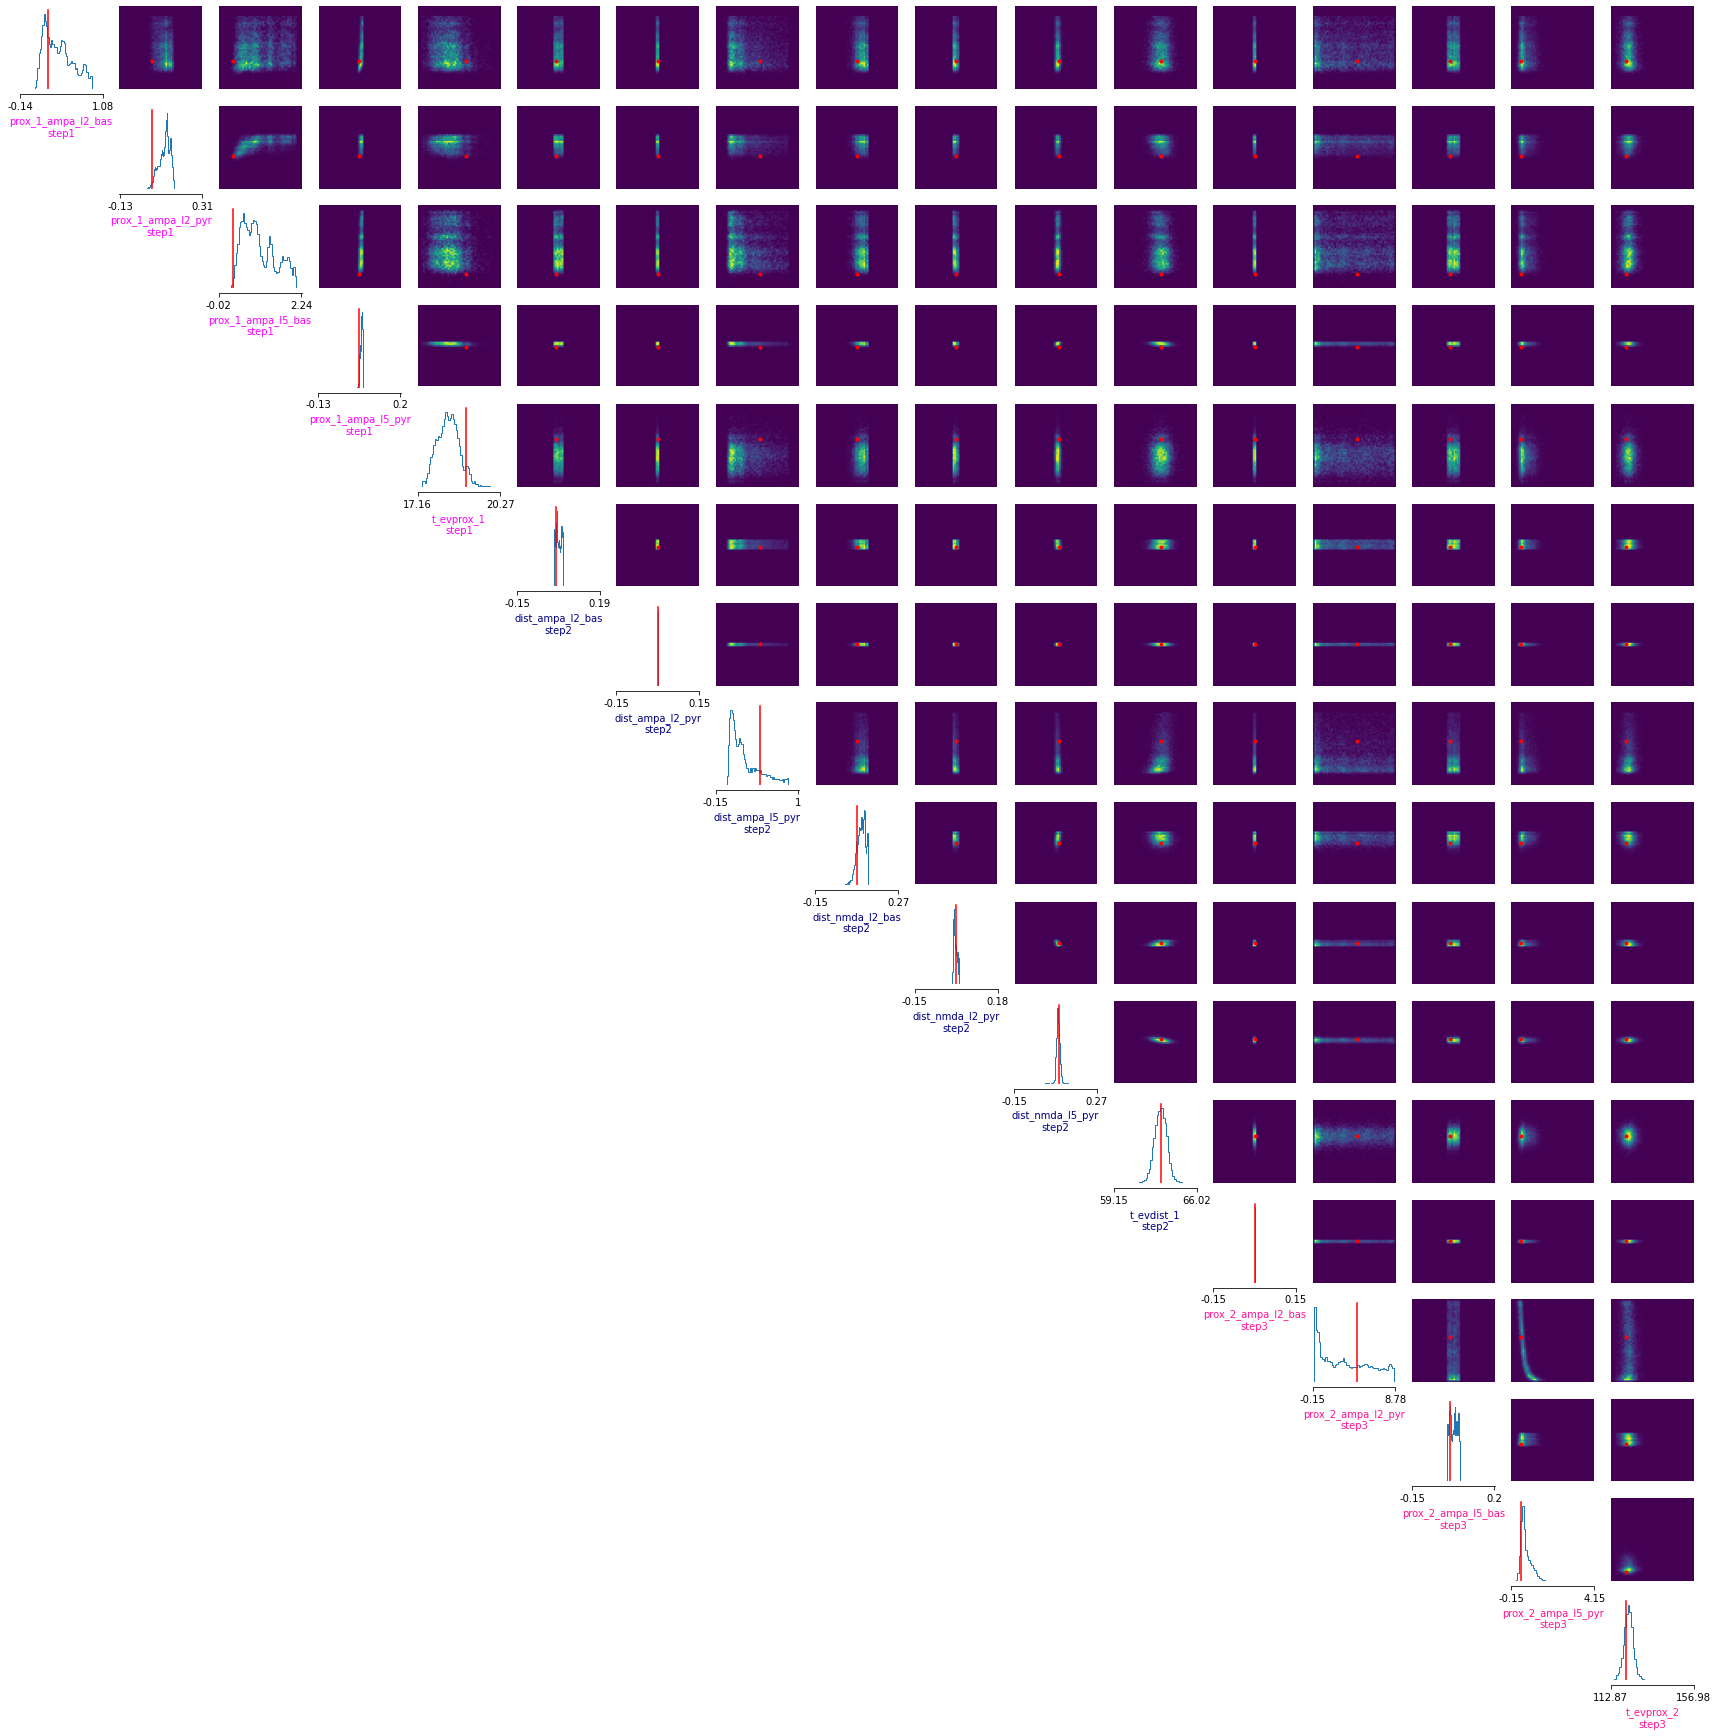

In [74]:
#limits = [list(tup) for tup in zip(prior_min, prior_max)]

fig, axes = analysis.pairplot(
    samples,
    limits=limits,
    ticks=np.round(limits,2),
    figsize=(30, 30),
    points=true_params,
    points_offdiag={"markersize": 6},
    points_colors="r",
    labels=parameter_names,
)

for i in range(5):
    axes[i][i].xaxis.label.set_color('magenta')
for i in range(5, 12):
    axes[i][i].xaxis.label.set_color('navy')
for i in range(12, 17):
    axes[i][i].xaxis.label.set_color('deeppink')

In [67]:
samples = posterior.sample((100,), x=obs_real)

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

In [68]:
s_x = inference.run_only_sim(samples, simulation_wrapper=sim_wrapper, num_workers=8)

early stopearly stop 170.0 
170.0param size  early stop17
early stop
 param size   17170.0
param size  170.0
17
param size 
 early stop17early stop
 170.0 
param size 170.0early stop 
17param size early stop 
  170.0170.0

param size  17
17
is here the problem?param size 
 17check

is here the problem?is here the problem?joblib will run over 1 jobs

is here the problem?
checkcheck

joblib will run over 1 jobs
joblib will run over 1 jobscheck
is here the problem?


checkjoblib will run over 1 jobs

joblib will run over 1 jobsis here the problem?
is here the problem?
check
check

is here the problem?
joblib will run over 1 jobsjoblib will run over 1 jobs

check
joblib will run over 1 jobs
[Parallel(n_jobs=8)]: Using backend MultiprocessingBackend with 8 concurrent workers.
Building the NEURON model
Building the NEURON modelBuilding the NEURON model

Building the NEURON model
Building the NEURON modelBuilding the NEURON model
Building the NEURON model

Building the NEURON model
[Done]
run

joblib will run over 1 jobs
[Parallel(n_jobs=8)]: Done  19 tasks      | elapsed:  5.3min
Simulation time: 150.0 ms...
Simulation time: 160.0 ms...
Building the NEURON model
Simulation time: 150.0 ms...
Simulation time: 150.0 ms...
Simulation time: 160.0 ms...
Simulation time: 160.0 ms...
[Done]
running trial 1 on 1 cores
early stop 170.0
param size  17
Simulation time: 0.03 ms...
is here the problem?
check
joblib will run over 1 jobs
[Parallel(n_jobs=8)]: Done  20 tasks      | elapsed:  5.4min
Simulation time: 160.0 ms...
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
Building the NEURON model
Simulation time: 160.0 ms...
early stop 170.0
param size  17
is here the problem?
check
joblib will run over 1 jobs
[Parallel(n_jobs=8)]: Done  21 tasks      | elapsed:  5.4min
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
Building the NEURON model
early stop 170.0
param size  17
is here the problem?
check
joblib will run over 1 jobs
[Parallel(n_jobs=8)]: Done  22 t

Simulation time: 60.0 ms...
Simulation time: 40.0 ms...
Simulation time: 80.0 ms...
Simulation time: 30.0 ms...
Simulation time: 60.0 ms...
Simulation time: 60.0 ms...
Simulation time: 50.0 ms...
Simulation time: 40.0 ms...
Simulation time: 90.0 ms...
Simulation time: 70.0 ms...
Simulation time: 50.0 ms...
Simulation time: 40.0 ms...
Simulation time: 70.0 ms...
Simulation time: 70.0 ms...
Simulation time: 60.0 ms...
Simulation time: 50.0 ms...
Simulation time: 100.0 ms...
Simulation time: 80.0 ms...
Simulation time: 60.0 ms...
Simulation time: 50.0 ms...
Simulation time: 80.0 ms...
Simulation time: 80.0 ms...
Simulation time: 70.0 ms...
Simulation time: 60.0 ms...
Simulation time: 110.0 ms...
Simulation time: 90.0 ms...
Simulation time: 70.0 ms...
Simulation time: 90.0 ms...
Simulation time: 60.0 ms...
Simulation time: 90.0 ms...
Simulation time: 120.0 ms...
Simulation time: 70.0 ms...
Simulation time: 80.0 ms...
Simulation time: 100.0 ms...
Simulation time: 80.0 ms...
Simulation time:

Simulation time: 30.0 ms...
Simulation time: 30.0 ms...
Simulation time: 70.0 ms...
Simulation time: 30.0 ms...
Simulation time: 80.0 ms...
Simulation time: 20.0 ms...
Simulation time: 30.0 ms...
Simulation time: 50.0 ms...
Simulation time: 40.0 ms...
Simulation time: 40.0 ms...
Simulation time: 80.0 ms...
Simulation time: 40.0 ms...
Simulation time: 90.0 ms...
Simulation time: 30.0 ms...
Simulation time: 40.0 ms...
Simulation time: 50.0 ms...
Simulation time: 50.0 ms...
Simulation time: 60.0 ms...
Simulation time: 90.0 ms...
Simulation time: 50.0 ms...
Simulation time: 100.0 ms...
Simulation time: 40.0 ms...
Simulation time: 100.0 ms...
Simulation time: 60.0 ms...
Simulation time: 60.0 ms...
Simulation time: 50.0 ms...
Simulation time: 70.0 ms...
Simulation time: 60.0 ms...
Simulation time: 110.0 ms...
Simulation time: 50.0 ms...
Simulation time: 110.0 ms...
Simulation time: 70.0 ms...
Simulation time: 70.0 ms...
Simulation time: 60.0 ms...
Simulation time: 80.0 ms...
Simulation time:

Simulation time: 60.0 ms...
Simulation time: 40.0 ms...
Simulation time: 80.0 ms...
Simulation time: 10.0 ms...
[Done]
running trial 1 on 1 cores
Simulation time: 30.0 ms...
Simulation time: 20.0 ms...
Simulation time: 0.03 ms...
Simulation time: 30.0 ms...
Simulation time: 70.0 ms...
Simulation time: 20.0 ms...
Simulation time: 50.0 ms...
Simulation time: 90.0 ms...
Simulation time: 40.0 ms...
Simulation time: 30.0 ms...
Simulation time: 10.0 ms...
Simulation time: 40.0 ms...
Simulation time: 80.0 ms...
Simulation time: 30.0 ms...
Simulation time: 100.0 ms...
Simulation time: 60.0 ms...
Simulation time: 50.0 ms...
Simulation time: 40.0 ms...
Simulation time: 20.0 ms...
Simulation time: 50.0 ms...
Simulation time: 40.0 ms...
Simulation time: 90.0 ms...
Simulation time: 110.0 ms...
Simulation time: 70.0 ms...
Simulation time: 50.0 ms...
Simulation time: 60.0 ms...
Simulation time: 30.0 ms...
Simulation time: 60.0 ms...
Simulation time: 50.0 ms...
Simulation time: 120.0 ms...
Simulation 

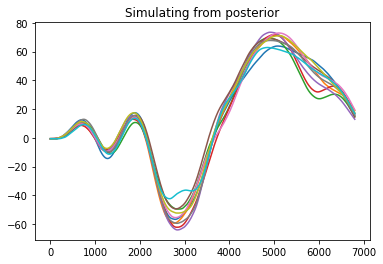

KeyboardInterrupt: 

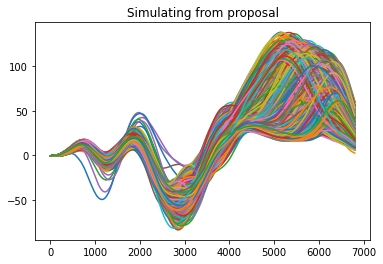

In [51]:
fig4, ax = plt.subplots(1, 1)
ax.set_title("Simulating from posterior")
for s in s_x:
    plt.plot(s)
plt.show()
    

fig3, ax = plt.subplots(1, 1)
ax.set_title("Simulating from proposal")
for x in x_without:
    plt.plot(x)
plt.show()

In [69]:
### sample from prior now
num_samples = 100
samples_prior = []


for i in range(num_samples):
    sample = prior.sample()
    samples_prior.append(sample)
    
s_x_prior = inference.run_only_sim(samples_prior, sim_wrapper, num_workers=8)

early stop early stop170.0early stop
 170.0early stop
 early stop param size 170.0 
early stopparam size param size 170.0 17 
 
1717early stop170.0early stopparam size  
  170.0
17170.0
param size  

param size 17param size   17170.0

 
17

param size  is here the problem?is here the problem?
17is here the problem?

check
check
is here the problem?
joblib will run over 1 jobs
joblib will run over 1 jobs
checkis here the problem?
check


is here the problem?joblib will run over 1 jobs

checkjoblib will run over 1 jobs

is here the problem?joblib will run over 1 jobs

checkcheck

joblib will run over 1 jobs
joblib will run over 1 jobs
is here the problem?
check
joblib will run over 1 jobs
[Parallel(n_jobs=8)]: Using backend MultiprocessingBackend with 8 concurrent workers.
Building the NEURON model
Building the NEURON model
Building the NEURON model
Building the NEURON model
Building the NEURON model
Building the NEURON model
Building the NEURON model
Building the NEURON model
[Done]
run

Simulation time: 160.0 ms...
Simulation time: 160.0 ms...
Building the NEURON model
early stop 170.0
param size  17
is here the problem?
check
joblib will run over 1 jobs
[Parallel(n_jobs=8)]: Done  19 tasks      | elapsed:  5.5min
Building the NEURON model
Simulation time: 160.0 ms...
early stop 170.0
param size  17
is here the problem?
early stopcheck 170.0

joblib will run over 1 jobsparam size 
 [Parallel(n_jobs=8)]: Done  20 tasks      | elapsed:  5.6min
[Parallel(n_jobs=8)]: Done  21 tasks      | elapsed:  5.6min
17
is here the problem?
check
joblib will run over 1 jobs
early stop 170.0
param size  17
is here the problem?
early stopcheck 
170.0
param size joblib will run over 1 jobsBuilding the NEURON model

 17
[Parallel(n_jobs=8)]: Done  22 tasks      | elapsed:  5.6min
[Parallel(n_jobs=8)]: Done  23 tasks      | elapsed:  5.6min
is here the problem?
check
joblib will run over 1 jobs
Building the NEURON model
Building the NEURON model
Building the NEURON model
early stop 170.0


Simulation time: 140.0 ms...
Simulation time: 150.0 ms...
Simulation time: 140.0 ms...
early stop 170.0
param size  17
is here the problem?
check
joblib will run over 1 jobs
[Parallel(n_jobs=8)]: Done  43 tasks      | elapsed: 11.0min
Building the NEURON model
Simulation time: 150.0 ms...
Simulation time: 160.0 ms...
Simulation time: 150.0 ms...
Simulation time: 160.0 ms...
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
Simulation time: 150.0 ms...
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
Simulation time: 160.0 ms...
early stop 170.0
param size  17
is here the problem?
check
joblib will run over 1 jobs
[Parallel(n_jobs=8)]: Done  44 tasks      | elapsed: 11.2min
Simulation time: 160.0 ms...
Building the NEURON model
[Done]
Simulation time: 10.0 ms...running trial 1 on 1 cores

Simulation time: 0.03 ms...
early stop 170.0
param size  17
is here the problem?
check
joblib will run over 1 jobs
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed: 11.2min


Simulation time: 140.0 ms...
Building the NEURON model
early stop 170.0
param size  17
is here the problem?
check
joblib will run over 1 jobs
[Parallel(n_jobs=8)]: Done  66 tasks      | elapsed: 16.6min
Building the NEURON model
early stop 170.0
param size  17
[Parallel(n_jobs=8)]: Done  67 tasks      | elapsed: 16.6min
is here the problem?
check
joblib will run over 1 jobs
Building the NEURON model
Simulation time: 160.0 ms...
Simulation time: 150.0 ms...
Simulation time: 140.0 ms...
Simulation time: 150.0 ms...
Simulation time: 160.0 ms...
early stop 170.0
param size  17
is here the problem?
check
joblib will run over 1 jobs
[Parallel(n_jobs=8)]: Done  68 tasks      | elapsed: 16.7min
Building the NEURON model
Simulation time: 160.0 ms...
Simulation time: 160.0 ms...
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
Simulation time: 150.0 ms...
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
early stop 170.0
param size  17
is here the problem?
check
joblib w

Simulation time: 140.0 ms...
Simulation time: 120.0 ms...
Simulation time: 150.0 ms...
Simulation time: 130.0 ms...
Simulation time: 160.0 ms...
Simulation time: 130.0 ms...
early stop 170.0
param size  17
is here the problem?
check
joblib will run over 1 jobs
Building the NEURON model
Simulation time: 130.0 ms...
Simulation time: 150.0 ms...
Simulation time: 140.0 ms...
Simulation time: 160.0 ms...
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
early stop 170.0
param size  17
is here the problem?
check
joblib will run over 1 jobs
[Parallel(n_jobs=8)]: Done  91 out of 100 | elapsed: 22.3min remaining:  2.2min
Building the NEURON model
Simulation time: 140.0 ms...
Simulation time: 160.0 ms...
Simulation time: 140.0 ms...
Simulation time: 150.0 ms...
early stop 170.0
param size  17
Simulation time: 10.0 ms...
is here the problem?
check
joblib will run over 1 jobs
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
Building the NEURON model
Simulation time: 150.0 

In [70]:
s_x_torch = torch.stack(([s_x[i] for i in range(len(s_x))]))
s_x_prior_torch = torch.stack(([s_x_prior[i] for i in range(len(s_x_prior))]))


mean = torch.mean(s_x_torch, 0)
std = torch.std(s_x_torch, 0)

mean_prior = torch.mean(s_x_prior_torch, 0)
std_prior = torch.std(s_x_prior_torch, 0)

lower = mean - 1.96 * std


upper = mean + 1.96 * std


lower_prior = mean_prior - 1.96 * std_prior


upper_prior = mean_prior + 1.96 * std_prior



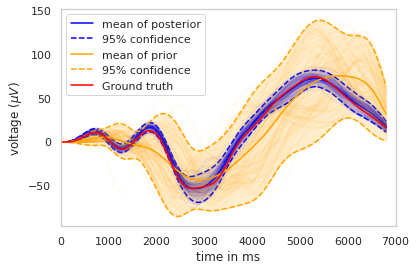

In [72]:
import seaborn as sns

sns.set() 

sns.set_style("whitegrid", {'axes.grid' : False})
#sns.set_style('ticks')

fig1, ax = plt.subplots(1, 1)
#ax.set_title("Comparing signal")

    
plt.plot(mean, color ='blue', label='mean of posterior')

for s in s_x:
    plt.plot(s, alpha=0.05, color='blue')
    #plt.ylim(-30,30)
    plt.xlim(0, 7000)

plt.plot(lower, color='blue', linestyle='dashed', label='95% confidence')
plt.plot(upper, color='blue', linestyle='dashed')
plt.fill_between(x= torch.arange(len(mean_prior)), y1=lower, y2=upper, color='blue', alpha=0.1)
plt.xlim(0, 7000)


plt.plot(mean_prior, color ='orange', label='mean of prior')


for x_w in s_x_prior:
    plt.plot(x_w, alpha=0.05, color='orange')

plt.plot(lower_prior, color='orange', linestyle='dashed', label='95% confidence')
plt.plot(upper_prior, color='orange', linestyle='dashed')
plt.fill_between(x= torch.arange(len(mean_prior)), y1=lower_prior, y2=upper_prior, color='orange', alpha=0.2)
plt.xlim(0, 7000)

plt.xlabel('time in ms')
#plt.ylabel('voltage ()')

fig1.gca().set_ylabel(r'voltage ($\mu V$)')
    
plt.plot(obs[0], label='Ground truth', color='red')

plt.legend()

In [73]:
s_x_prior_stat = calculate_summary_stats_temporal(s_x_prior)
s_x_stat = calculate_summary_stats_temporal(s_x)
                                                

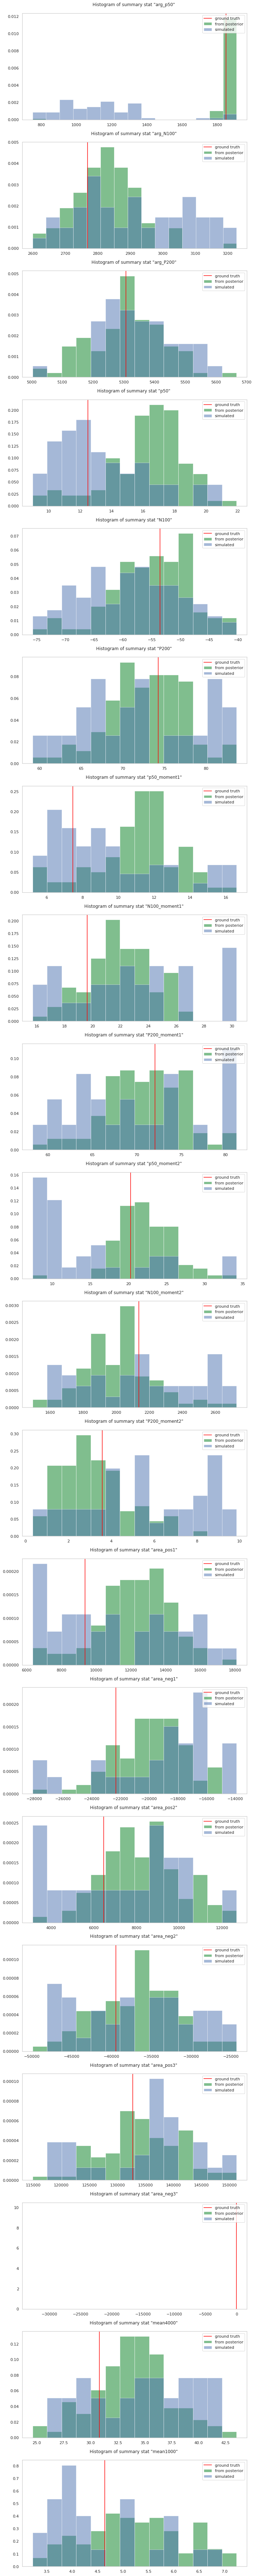

In [123]:
import matplotlib.gridspec as gridspec

sum_stats_names =                  [
                    'arg_p50',
                    'arg_N100',
                    'arg_P200',
                    'p50',
                    'N100',
                    'P200',
                    'p50_moment1',
                    'N100_moment1',
                    'P200_moment1',
                    'p50_moment2',
                    'N100_moment2',
                    'P200_moment2',
                    'area_pos1',
                    'area_neg1',
                    'area_pos2',
                    'area_neg2',
                    'area_pos3',
                    'area_neg3',
                    'mean4000',
                    'mean1000'
                ]

fig = plt.figure(figsize=(10,5*len(s_x_stat[0])), tight_layout=True)

gs = gridspec.GridSpec(nrows=len(sum_stats_names), ncols=1)



#fig.suptitle('Summary stats histogram from posterior predictions.', y=0.2, fontsize=16)


for i in range(len(sum_stats_names)):

    globals()['ax%s' % i] = fig.add_subplot(gs[i])

    globals()['sum_stats%s' % i] = []
    globals()['x%s' % i] = []

    for j in range(len(s_x)):
        globals()['sum_stats%s' % i].append(float(s_x_stat[j][i]))
        globals()['x%s' % i].append(float(s_x_prior_stat[j][i]))

    sum_stat = globals()['sum_stats%s' % i]
    
    
    ##define bins such that we get an equal number of bins at the end:
   
    a = abs(max(sum_stat)-min(sum_stat))
    binsteps = np.divide(a, 15, out=np.zeros_like(a))
      
    if binsteps==0:
        
        binrange = 10
    else:

        binrange = np.arange(min(sum_stat), max(sum_stat), binsteps)
    
    globals()['ax%s' % i].hist(globals()['sum_stats%s' % i],  density=True, bins = binrange, facecolor='g', alpha=0.75, histtype='barstacked', label='from posterior')
    globals()['ax%s' % i].hist(globals()['x%s' % i],  density=True, bins = binrange, facecolor='b', alpha=0.5, histtype='barstacked', label='simulated')
    
  
    globals()['ax%s' % i].set_title('Histogram of summary stat "{}" '.format(sum_stats_names[i]), pad=20)
    #ax0.set(ylim=(-500, 7000))

    globals()['ax%s' % i].axvline(obs_real[0][i].detach().numpy(), color='red', label='ground truth')
    globals()['ax%s' % i].legend(loc='upper right')